In [1]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter, FuncAnimation
import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3
import warnings
from matplotlib.animation import FFMpegWriter
from shapely.geometry import Point, LineString
from loguru import logger
from IPython.display import Image
from matplotlib.collections import LineCollection
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
import shutil
from tqdm import tqdm
import datetime

warnings.filterwarnings("ignore", category=UserWarning, module="osmnx")
pd.set_option("display.float_format", "{:.6f}".format)

In [2]:
def round_to_nearest_30min(dt):
    # Compute how many seconds have passed since the last 30-min mark
    discard = datetime.timedelta(minutes=dt.minute % 30,
                                seconds=dt.second,
                                microseconds=dt.microsecond)
    dt -= discard
    # if remainder >= 15 minutes, round up
    if discard >= datetime.timedelta(minutes=15):
        dt += datetime.timedelta(minutes=30)
    return dt

In [3]:
def plot_dynamic(df):
    import tkinter as tk
    from tkinter import ttk
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
    from datetime import datetime
    import geopandas as gpd
    # from shapely import wkt
    # import osmnx as ox

    # -------------------------
    # --- Data (adjust names)
    # -------------------------
    # Assumes you already have `temp`, `warsaw`, `districts`, `gminy` loaded in the environment.
    # Replace `temp` with your dataframe variable if different.
    # Make sure geodataframe projected to webmercator for x/y coords
    df = df.to_crs(epsg=3857)
    df["x"] = df.geometry.x
    df["y"] = df.geometry.y

    # Ensure time column exists and is datetime
    if "time" in df.columns:
        df["time"] = pd.to_datetime(df["time"])
    else:
        # If you have different column name for time, adjust here
        raise RuntimeError("DataFrame must contain a 'time' column")

    # Prepare stringified unique IDs for searchable combobox
    unique_ids_str = sorted(df["id"].dropna().astype(str).unique())
    id_values_all = ["All"] + unique_ids_str

    # -------------------------
    # --- Tkinter UI
    # -------------------------
    root = tk.Tk()
    root.title("Time + Afterglow Plot")
    root.geometry("950x750")

    # --- Matplotlib figure + canvas + toolbar ---
    fig, ax = plt.subplots()
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

    toolbar = NavigationToolbar2Tk(canvas, root)
    toolbar.update()
    toolbar.pack(side=tk.TOP, fill=tk.X)

    # Draw basemap once (keeps zoom intact later)
    try:
        warsaw.boundary.plot(ax=ax, linewidth=2.5, color="black", rasterized=True)
        districts.boundary.plot(ax=ax, linewidth=0.8, color="gray", alpha=0.9, rasterized=True)
        gminy.boundary.plot(ax=ax, linewidth=1.5, color="gray", alpha=0.9)
    except Exception:
        # If those GeoDataFrames are not defined in scope, ignore drawing
        pass

    # Set a slightly expanded initial view based on warsaw bounds if available
    try:
        magnify_factor_y = 0.005
        magnify_factor_x = 0.015
        magnify_factor_y = 0.005
        magnify_factor_x = 0.015
        minx, miny, maxx, maxy = warsaw.total_bounds
        minx *= (1-magnify_factor_x)
        miny *= (1-magnify_factor_y)
        maxx *= (1+magnify_factor_x)
        maxy *= (1+magnify_factor_y)
        ax.set_xlim((minx, maxx))
        ax.set_ylim((miny, maxy))
    except Exception:
        # fallback to current autoscale limits
        initial_xlim = ax.get_xlim()
        initial_ylim = ax.get_ylim()

    # Create persistent artists (empty initially); these will be updated in-place
    line_artist, = ax.plot([], [], linewidth=1.5, alpha=0.8, zorder=3)
    scatter_artist = ax.scatter([], [], s=30, alpha=1.0, zorder=2)
    latest_artist = ax.scatter([], [], s=80, color="red", zorder=10)

    # Prevent autoscale recalculation when artist data changes
    ax.set_autoscale_on(False)

    # --- Controls frame ---
    frame = tk.Frame(root)
    frame.pack(side=tk.BOTTOM, fill=tk.X, padx=10, pady=10)

    show_all_var = tk.IntVar()
    show_all_checkbox = tk.Checkbutton(frame, text="Show all", variable=show_all_var)
    show_all_checkbox.grid(row=0, column=0, padx=5)

    id_var = tk.StringVar(value="All")
    id_label = tk.Label(frame, text="Filter by ID")
    id_label.grid(row=0, column=1, padx=5)

    # Searchable (editable) combobox
    id_dropdown = ttk.Combobox(frame, textvariable=id_var, values=id_values_all, state="normal", width=30)
    id_dropdown.grid(row=0, column=2, padx=5)

    slider_label = tk.Label(frame, text="Time")
    slider_label.grid(row=0, column=3, padx=5)

    time_slider = tk.Scale(frame, from_=0, to=len(df)-1, orient=tk.HORIZONTAL, length=400)
    time_slider.set(len(df)-1)
    time_slider.grid(row=0, column=4, padx=5)

    # -------------------------
    # --- Helper functions
    # -------------------------
    def update_slider_range():
        """
        Update slider range based on current ID filter (substring match on id strings).
        """
        val = id_var.get().strip()
        if val and val.lower() != "all":
            df_filtered = df[df["id"] == val]
        else:
            df_filtered = df

        if df_filtered.empty:
            time_slider.config(from_=0, to=0)
            time_slider.set(0)
        else:
            time_slider.config(from_=0, to=len(df_filtered)-1)
            time_slider.set(len(df_filtered)-1)

    def filter_df_by_id_and_time():
        """
        Return the dataframe filtered by the ID substring and slider position (unless show_all).
        """
        val = id_var.get().strip()
        if val and val.lower() != "all":
            df_filtered = df[df["id"] == val].copy()
        else:
            df_filtered = df.copy()

        if df_filtered.empty:
            return df_filtered

        # apply time slider slicing (index-based)
        df_filtered = df_filtered.sort_values("time")  # ensure chronological
        if not show_all_var.get():
            idx = int(time_slider.get())
            df_filtered = df_filtered.iloc[: idx + 1]

        return df_filtered

    def on_id_keyrelease(event):
        """
        Filter the combobox dropdown list as the user types (searchable combobox).
        """
        typed = id_var.get().strip()
        if typed == "" or typed.lower() == "all":
            new_values = ["All"] + unique_ids_str
        else:
            matches = [v for v in unique_ids_str if typed.lower() in v.lower()]
            new_values = ["All"] + matches

        id_dropdown["values"] = new_values
        # Optionally open dropdown to show suggestions
        try:
            id_dropdown.event_generate('<Down>')
        except Exception:
            pass

        update_slider_range()
        update_plot()

    # -------------------------
    # --- Core update function
    # -------------------------
    def update_plot(*args):
        """
        Update only the line/scatter/latest artists so the basemap and zoom remain unchanged.
        """
        # save current view limits
        try:
            current_xlim = ax.get_xlim()
            current_ylim = ax.get_ylim()
        except Exception:
            current_xlim = None
            current_ylim = None

        # get filtered data
        df_filtered = filter_df_by_id_and_time()

        # if no data, clear artists and restore view
        if df_filtered.empty:
            line_artist.set_data([], [])
            scatter_artist.set_offsets(np.empty((0, 2)))
            latest_artist.set_offsets(np.empty((0, 2)))
            slider_label.config(text="Time: ")
            ax.set_title("")
            if current_xlim and current_ylim:
                ax.set_xlim(current_xlim)
                ax.set_ylim(current_ylim)
            else:
                ax.set_xlim(initial_xlim)
                ax.set_ylim(initial_ylim)
            canvas.draw_idle()
            return

        # prepare XY arrays
        xs = df_filtered["x"].to_numpy()
        ys = df_filtered["y"].to_numpy()

        # update artists (in-place)
        line_artist.set_data(xs, ys)
        scatter_artist.set_offsets(np.column_stack((xs, ys)))

        latest = df_filtered.iloc[-1]
        latest_xy = np.array([[latest["x"], latest["y"]]])
        latest_artist.set_offsets(latest_xy)

        # format time as HH:MM:SS
        try:
            latest_time_str = pd.to_datetime(latest["time"]).strftime("%H:%M:%S")
        except Exception:
            latest_time_str = str(latest.get("time", ""))

        # optional title extra
        title_extra = ""
        if "time_bucket_difference" in df_filtered.columns:
            try:
                title_extra = f", max: {df_filtered['time_bucket_difference'].max()}"
            except Exception:
                title_extra = ""

        slider_label.config(text=f"Time: {latest_time_str}")
        ax.set_title(f"{latest_time_str}{title_extra}")

        # restore previous view limits unless toolbar pan/zoom is active
        try:
            toolbar_active = getattr(toolbar, "mode", "") != ""
        except Exception:
            toolbar_active = False

        if not toolbar_active:
            if current_xlim and current_ylim:
                ax.set_xlim(current_xlim)
                ax.set_ylim(current_ylim)
            else:
                ax.set_xlim(initial_xlim)
                ax.set_ylim(initial_ylim)

        canvas.draw_idle()

    # -------------------------
    # --- Bind events
    # -------------------------
    id_dropdown.bind("<KeyRelease>", on_id_keyrelease)
    id_dropdown.bind("<<ComboboxSelected>>", lambda e: (update_slider_range(), update_plot()))
    time_slider.config(command=lambda val: update_plot())
    show_all_var.trace_add("write", lambda *args: update_plot())

    # Also update when id_var is changed programmatically
    id_var.trace_add("write", lambda *args: (update_slider_range(), update_plot()))

    # -------------------------
    # --- Initialize UI
    # -------------------------
    update_slider_range()
    update_plot()

    root.mainloop()


In [4]:
def plot_rejected(rejected_df):
    minx, miny, maxx, maxy = warsaw.total_bounds
    minx *= 0.9995
    miny *= 0.9998
    maxx *= 1.0005
    maxy *= 1.0001

    fig_width = 16
    width = maxx - minx
    height = maxy - miny
    aspect = height / width
    fig_height = int(fig_width * aspect)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # =========================
    # BACKGROUND MAP
    # =========================
    districts.boundary.plot(ax=ax, linewidth=0.5, color="black", rasterized=True)
    gminy.boundary.plot(ax=ax, linewidth=1, color="black", rasterized=True)
    warsaw.boundary.plot(ax=ax, linewidth=2.9, color="black", rasterized=True)
    rejected_df.plot(ax=ax)


    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect("equal")
    ax.set_axis_off()
    ax.margins(0)
    ax.set_position([0, 0, 1, 1])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.set_autoscale_on(False)

In [5]:
data_parent_directory = "../../data"
data_parent_directory_maps = f"{data_parent_directory}/maps"
table_name = "vehicles"
file_name = "vehicles"

database_file_path = f"{data_parent_directory}/{file_name}.db"

def print_removed(df, mask, operation="Removed"):
    logger.info(f"{operation} {mask.sum()} out of {len(df)} rows which is {mask.sum()/len(df):.2%} of all.")
    
    stats = df.assign(mask=mask)

    id_stats = (
        stats
        .groupby("id", as_index=False)
        .agg(
            total_rows=("id", "size"),
            removed_rows=("mask", "sum"),
        )
    )

    fully_removed = id_stats.loc[
        id_stats["removed_rows"] == id_stats["total_rows"], "id"
    ]

    partially_removed = id_stats.loc[
        (id_stats["removed_rows"] > 0) &
        (id_stats["removed_rows"] < id_stats["total_rows"]), "id"
    ]

    logger.info(
        f"Fully removed ids ({len(fully_removed)}): {fully_removed.tolist()}"
    )

    logger.info(
        f"Partially removed ids ({len(partially_removed)}): {partially_removed.tolist()}"
    )
    
    return list(fully_removed)
    

In [6]:
save_maps_to_file = False

filter_gminy = ["powiat " + item for item in [
    "wołomiński",
    "pruszkowski",
    "miński",
    "otwocki",
    "piaseczyński",
    "warszawski zachodni",
    "nowodworski",
    "legionowski",
    ]]

warsaw = ox.geocode_to_gdf("Warsaw, Poland")
districts = ox.features_from_place(
    "Warsaw, Poland",
    {"boundary": "administrative", "admin_level": "9"}
)
gminy = ox.features_from_place(
    "Masovian Voivodeship, Poland",
    {"admin_level": "6"}
)
river_area = ox.features_from_place(
    "Masovian Voivodeship, Poland",
    {"natural": "water", "water": "river"} 
)

river_way = ox.features_from_place(
    "Masovian Voivodeship, Poland",
    {"waterway": ["river", "canal"]}
)

districts = districts[districts["admin_level"] == "9"]
districts = districts[districts.geom_type == "Polygon"]
districts = districts[districts["boundary"].notnull()]
districts = districts[districts["wikidata"].notnull()]

gminy = gminy[gminy["boundary"] == "administrative"]
gminy = gminy[gminy["admin_level"] == "6"]
gminy = gminy[gminy.geom_type == "Polygon"]
gminy = gminy[gminy["name"].isin(filter_gminy)]
gminy = gminy.drop_duplicates()

river_way = river_way[river_way["name"].isin(["Wisła", "Kanał Żerański", "Świder"])]
river_area = river_area[(river_area["natural"] == "water") & (river_area["water"].isin(["river", "canal"]))]
river_area = river_area[["geometry"]]
river_area = river_area.reset_index()

rivers = gpd.sjoin(
    river_area,
    river_way[["geometry"]],
    how="inner",
    predicate="intersects"
)

warsaw = warsaw.to_crs(epsg=3857)
districts = districts.to_crs(epsg=3857)
gminy = gminy.to_crs(epsg=3857)
rivers = rivers.to_crs(epsg=3857)

if save_maps_to_file:
    warsaw.to_file(f"{data_parent_directory_maps}/warsaw_outline.shp")
    districts.to_file(f"{data_parent_directory_maps}/warsaw_districts.shp")
    gminy.to_file(f"{data_parent_directory_maps}/gminy.shp")
    rivers.to_file(f"{data_parent_directory}/rivers.shp")

In [7]:
# Here I get gps information about buses and trams

conn = sqlite3.connect(database_file_path)
gps_data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

gps_data = gpd.GeoDataFrame(gps_data, geometry=gpd.points_from_xy(gps_data["lon"], gps_data["lat"]))
gps_data = gps_data.drop(columns=["lon", "lat", "id"])
gps_data = gps_data.drop_duplicates()
gps_data = gps_data.set_crs(epsg=4326) # it"s standard coordinate system with degrees
# calculate distances and velocities in 2180 because it"s in meters, and later convert it to 3857

gps_data["time"] = pd.to_datetime(gps_data["time"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

gps_data["type"] = gps_data["line"].apply(
    lambda x: "night_bus" if str(x).startswith("N")
    else "tram" if str(x).isdigit() and len(x) <= 2
    else "bus"
)

gps_data

,time,line,vehicle_number,brigade,geometry,type
0,2025-03-09 11:20:17,119,1000,3,POINT (21.02194 52.20786),bus
1,2025-03-09 04:44:10,219,1001,3,POINT (21.1176 52.23413),bus
2,2025-03-09 11:20:03,219,1002,2,POINT (21.10244 52.22279),bus
3,2025-03-09 11:20:10,119,1003,1,POINT (21.20567 52.21004),bus
4,2025-03-09 11:20:04,196,1004,1,POINT (21.17813 52.2585),bus
...,...,...,...,...,...,...
609807,2025-03-09 13:33:18,16,4281,8,POINT (21.00829 52.23567),tram
609808,2025-03-09 13:33:18,16,4282,1,POINT (20.96488 52.26625),tram
609809,2025-03-09 13:33:15,2,4283,6,POINT (20.95537 52.31722),tram
609810,2025-03-09 13:33:16,33,4284,9,POINT (20.92596 52.28089),tram


In [8]:
# Here I:
# - convert the epsg to 2180
# - create unique id made out of line number, brigade and vehicle number
# - calculate movement (dx and dy) in meters
# - calculate position change (?) like dr in meters as well
# - calculate time between next movements 
# - calculate speed in kilometers per second

gps_data_processed = gps_data.copy()
gps_data_processed = gps_data_processed.to_crs(epsg="2180")
gps_data_processed["id"] = gps_data_processed[["line", "vehicle_number", "brigade"]].astype(str).agg("|".join, axis=1)
gps_data_processed = gps_data_processed.drop_duplicates(subset=["id", "time"])
gps_data_processed = gps_data_processed.sort_values(["id", "time"])

gps_data_processed["x"] = gps_data_processed.geometry.x
gps_data_processed["y"] = gps_data_processed.geometry.y

gps_data_processed["dx"] = gps_data_processed.groupby("id")["x"].diff()
gps_data_processed["dy"] = gps_data_processed.groupby("id")["y"].diff()
gps_data_processed["dr"] = np.hypot(gps_data_processed["dx"], gps_data_processed["dy"])

gps_data_processed["dt"] = gps_data_processed.groupby("id")["time"].diff().dt.total_seconds()

gps_data_processed["speed"] = gps_data_processed["dr"] / gps_data_processed["dt"] * 3.6
gps_data_processed["speed"] = gps_data_processed["speed"].fillna(0)

mask_infinite_speed = gps_data_processed["speed"] == np.inf
logger.info(f"Replaced {mask_infinite_speed.sum()} rows with 1000 km/h.")
gps_data_processed.loc[mask_infinite_speed, "speed"] = 1000

gps_data_processed = gps_data_processed.drop(columns=["dx", "dy", "x", "y"])
gps_data_processed

2026-01-15 13:13:30.446 | INFO     | __main__:<module>:28 - Replaced 0 rows with 1000 km/h.


,time,line,vehicle_number,brigade,geometry,type,id,dr,dt,speed
655,2024-11-22 10:44:27,100,4942,M1,POINT (634305.01 491173.647),bus,100|4942|M1,NaN,NaN,0.000000
165166,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585,NaN,NaN,0.000000
167705,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585,1.686402,36.000000,0.168640
170245,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585,1.566556,47.000000,0.119992
172785,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585,1.502058,31.000000,0.174433
...,...,...,...,...,...,...,...,...,...,...
596476,2025-03-09 13:30:16,ZM1,9853,4,POINT (641512.204 475741.96),bus,ZM1|9853|4,1.522951,28.000000,0.195808
599017,2025-03-09 13:30:49,ZM1,9853,4,POINT (641513.553 475742.666),bus,ZM1|9853|4,1.522951,33.000000,0.166140
601558,2025-03-09 13:31:38,ZM1,9853,4,POINT (641524.007 475736.288),bus,ZM1|9853|4,12.245308,49.000000,0.899655
604096,2025-03-09 13:32:22,ZM1,9853,4,POINT (641513.572 475741.999),bus,ZM1|9853|4,11.894818,44.000000,0.973212


In [9]:
# This code interpolates if the speed of either bus or tram is greater than a given threshold (120 km/s for buses
# and 80 km/s for trams)

MAX_SPEED_THRESHOLD_BUS = 120
MAX_SPEED_THRESHOLD_TRAM = 80

gps_data_top_speed = gps_data_processed.copy()

gps_data_top_speed["x"] = gps_data_top_speed["geometry"].x
gps_data_top_speed["y"] = gps_data_top_speed["geometry"].y

mask_fast = (
    ((gps_data_top_speed["speed"] > MAX_SPEED_THRESHOLD_BUS) & (gps_data_top_speed["type"] != "tram")) |
    ((gps_data_top_speed["speed"] > MAX_SPEED_THRESHOLD_TRAM) & (gps_data_top_speed["type"] == "tram"))
)

def detect_teleports(group):
    teleport = (
        ((group["speed"] >= MAX_SPEED_THRESHOLD_BUS) & (group["type"] != "tram")) |
        ((group["speed"] >= MAX_SPEED_THRESHOLD_TRAM) & (group["type"] == "tram"))
    )
    if not teleport.any():
        return group.assign(teleport=False)

    first = teleport.idxmax()
    last = teleport[::-1].idxmax()

    group["teleport"] = False
    group.loc[first:last, "teleport"] = True

    return group

gps_data_top_speed = gps_data_top_speed.groupby(["id"], as_index=False).apply(detect_teleports, include_groups=True).reset_index(drop=True)
gps_data_top_speed.loc[gps_data_top_speed["teleport"], ["x", "y"]] = np.nan

interp_xy = (
    gps_data_top_speed
        .groupby("id", group_keys=False)
        .apply(
            lambda g: (
                g.set_index("time")[["x", "y"]]
                 .interpolate(
                     method="time",
                     limit=8,
                     limit_direction="both"
                 )
                 .reset_index()
            )
        )
)

gps_data_top_speed.loc[interp_xy.index, ["x", "y"]] = interp_xy

print_removed(gps_data_top_speed, gps_data_top_speed["teleport"], "Modified")

gps_data_top_speed.loc[gps_data_top_speed["teleport"], "geometry"] = [
    Point(xy) for xy in zip(
        gps_data_top_speed.loc[gps_data_top_speed["teleport"], "x"], 
        gps_data_top_speed.loc[gps_data_top_speed["teleport"], "y"]
        )
    ]

gps_data_top_speed = gps_data_top_speed.dropna(subset=["x", "y"])
gps_data_top_speed = gps_data_top_speed.drop(columns=["x", "y", "teleport"])
gps_data_top_speed

C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\370288426.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_top_speed = gps_data_top_speed.groupby(["id"], as_index=False).apply(detect_teleports, include_groups=True).reset_index(drop=True)
C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\370288426.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
2026-01-15 13:13:39.627 | INFO    

,time,line,vehicle_number,brigade,geometry,type,id,dr,dt,speed
0,2024-11-22 10:44:27,100,4942,M1,POINT (634305.01 491173.647),bus,100|4942|M1,NaN,NaN,0.000000
1,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585,NaN,NaN,0.000000
2,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585,1.686402,36.000000,0.168640
3,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585,1.566556,47.000000,0.119992
4,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585,1.502058,31.000000,0.174433
...,...,...,...,...,...,...,...,...,...,...
276461,2025-03-09 13:30:16,ZM1,9853,4,POINT (641512.204 475741.96),bus,ZM1|9853|4,1.522951,28.000000,0.195808
276462,2025-03-09 13:30:49,ZM1,9853,4,POINT (641513.553 475742.666),bus,ZM1|9853|4,1.522951,33.000000,0.166140
276463,2025-03-09 13:31:38,ZM1,9853,4,POINT (641524.007 475736.288),bus,ZM1|9853|4,12.245308,49.000000,0.899655
276464,2025-03-09 13:32:22,ZM1,9853,4,POINT (641513.572 475741.999),bus,ZM1|9853|4,11.894818,44.000000,0.973212


In [10]:
temp = gps_data_top_speed.copy()
temp = temp[temp["id"] == "154|4230|4"]
temp.to_excel("temp.xlsx", index=False)
temp

,time,line,vehicle_number,brigade,geometry,type,id,dr,dt,speed
72859,2025-03-09 11:20:19,154,4230,4,POINT (635193.199 484288.509),bus,154|4230|4,NaN,NaN,0.000000
72860,2025-03-09 11:20:53,154,4230,4,POINT (635270.327 484495.623),bus,154|4230|4,221.009547,34.000000,23.401011
72861,2025-03-09 11:21:25,154,4230,4,POINT (635267.892 484528.478),bus,154|4230|4,32.945425,32.000000,3.706360
72862,2025-03-09 11:21:48,154,4230,4,POINT (635127.491 484563.474),bus,154|4230|4,144.696172,23.000000,22.648097
72863,2025-03-09 11:22:21,154,4230,4,POINT (635071.193 484586.014),bus,154|4230|4,60.642916,33.000000,6.615591
...,...,...,...,...,...,...,...,...,...,...
73094,2025-03-09 13:30:54,154,4230,4,POINT (632906.909 480725.77),bus,154|4230|4,86.708241,34.000000,9.180873
73095,2025-03-09 13:31:39,154,4230,4,POINT (632949.852 480732.095),bus,154|4230|4,43.405558,45.000000,3.472445
73096,2025-03-09 13:32:23,154,4230,4,POINT (632895.045 480613.917),bus,154|4230|4,130.268363,44.000000,10.658321
73097,2025-03-09 13:32:47,154,4230,4,POINT (632902.943 480603.314),bus,154|4230|4,13.220370,24.000000,1.983056


In [11]:
# This is purely for invalid data that I downloaded long time ago. I should remove it as soon as I get fresh data.

gps_data_time_outliers = gps_data_top_speed.copy()
mask_valid_dates = gps_data_time_outliers["time"] < pd.Timestamp("2025-03-15")
mask_valid_dates &= gps_data_time_outliers["time"] > pd.Timestamp("2025-03-01")

print_removed(gps_data_time_outliers, ~mask_valid_dates)
gps_data_time_outliers = gps_data_time_outliers[mask_valid_dates]
gps_data_time_outliers

2026-01-15 13:13:40.604 | INFO     | __main__:print_removed:9 - Removed 191 out of 276147 rows which is 0.07% of all.
2026-01-15 13:13:40.696 | INFO     | __main__:print_removed:31 - Fully removed ids (191): ['100|4942|M1', '102|4518|581', '102|7200|581', '103|9453|1', '103|9547|1', '104|9403|1', '105|7219|1', '105|9695|1', '106|952|6', '106|9679|1', '106|9685|4', '106|9686|1', '107|9251|M2', '107|9672|4', '107|9680|3', '107|9696|1', '108|9687|1', '10|3266|9', '110|9415|1', '110|9416|M3', '110|9455|1', '114|9694|3', '115|9690|3', '117|1106|06', '117|1509|06', '117|9419|1', '117|9420|2', '117|9421|4', '117|9434|3', '119|1869|1', '122|1102|012', '122|1115|014', '123|1117|2', '126|1112|3', '131|8368|3', '132|3425|1', '132|3429|2', '133|9205|1', '134|9402|4', '134|9424|1', '134|9425|3', '134|9457|2', '136|2043|8', '13|3828|5', '141|5234|2', '14|4264|2', '150|733|011', '152|9411|2', '152|9426|3', '152|9427|4', '152|9440|1', '156|1501|3', '156|9697|5', '156|9698|1', '157|9401|4', '157|9404|1

,time,line,vehicle_number,brigade,geometry,type,id,dr,dt,speed
1,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585,NaN,NaN,0.000000
2,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585,1.686402,36.000000,0.168640
3,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585,1.566556,47.000000,0.119992
4,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585,1.502058,31.000000,0.174433
5,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585,0.341377,25.000000,0.049158
...,...,...,...,...,...,...,...,...,...,...
276461,2025-03-09 13:30:16,ZM1,9853,4,POINT (641512.204 475741.96),bus,ZM1|9853|4,1.522951,28.000000,0.195808
276462,2025-03-09 13:30:49,ZM1,9853,4,POINT (641513.553 475742.666),bus,ZM1|9853|4,1.522951,33.000000,0.166140
276463,2025-03-09 13:31:38,ZM1,9853,4,POINT (641524.007 475736.288),bus,ZM1|9853|4,12.245308,49.000000,0.899655
276464,2025-03-09 13:32:22,ZM1,9853,4,POINT (641513.572 475741.999),bus,ZM1|9853|4,11.894818,44.000000,0.973212


In [12]:
# Minimum points for plotting a vehicle is equal to 24

MIN_DATA_PER_ROUTE = 24

gps_data_long = gps_data_time_outliers.copy()

mask_long_routes = gps_data_long.groupby("id")["id"].transform("size") >= MIN_DATA_PER_ROUTE
removed = print_removed(gps_data_long, ~mask_long_routes)

gps_data_rejected = gps_data_long[~mask_long_routes].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_long = gps_data_long[mask_long_routes]

gps_data_long

2026-01-15 13:13:40.881 | INFO     | __main__:print_removed:9 - Removed 2007 out of 275956 rows which is 0.73% of all.
2026-01-15 13:13:40.968 | INFO     | __main__:print_removed:31 - Fully removed ids (1175): ['102|1415|581', '102|7327|545', '102|8583|09', '103|9501|1', '103|9503|1', '103|9549|2', '103|9550|3', '103|9551|6', '103|9553|4', '103|9558|3', '104|9079|1', '105|2211|1', '105|2213|09', '105|2220|08', '105|2237|6', '105|4520|1', '105|4524|4', '105|5243|3', '106|1811|2', '106|1903|5', '106|4413|4', '107|1033|9', '107|1062|2', '107|4308|2', '108|1021|2', '108|1023|1', '108|1024|2', '108|1027|3', '10|1390|018', '10|1396|015', '10|1450|13', '10|1458|7', '10|1466|6', '10|2032|016', '10|2056|016', '10|2122|5', '10|2124|10', '10|2126|015', '10|3121|8', '110|762|1', '111|2023|7', '111|5902|012', '111|5967|603', '111|5979| ', '111|5986|608', '112|3405|2', '112|3462|8', '112|5206|9', '112|7210|10', '112|7222|7', '112|8441|4', '112|8447|3', '112|8462|1', '112|9927|012', '112|9949|014', '

,time,line,vehicle_number,brigade,geometry,type,id,dr,dt,speed
1,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585,NaN,NaN,0.000000
2,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585,1.686402,36.000000,0.168640
3,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585,1.566556,47.000000,0.119992
4,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585,1.502058,31.000000,0.174433
5,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585,0.341377,25.000000,0.049158
...,...,...,...,...,...,...,...,...,...,...
276461,2025-03-09 13:30:16,ZM1,9853,4,POINT (641512.204 475741.96),bus,ZM1|9853|4,1.522951,28.000000,0.195808
276462,2025-03-09 13:30:49,ZM1,9853,4,POINT (641513.553 475742.666),bus,ZM1|9853|4,1.522951,33.000000,0.166140
276463,2025-03-09 13:31:38,ZM1,9853,4,POINT (641524.007 475736.288),bus,ZM1|9853|4,12.245308,49.000000,0.899655
276464,2025-03-09 13:32:22,ZM1,9853,4,POINT (641513.572 475741.999),bus,ZM1|9853|4,11.894818,44.000000,0.973212


In [13]:
# Here I remove stationary vehicles, on loops or stationary

EPS = 60
MIN_SAMPLES = 5
MAXIMUM_RANGE = 500

def detect_loops(group):
    TIME_SCALE = 1
    group["spacial_drift"] = (group["time"] - group["time"].min()).dt.total_seconds() * TIME_SCALE

    coords = group[["x", "y", "spacial_drift"]].values
    
    db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(coords)
    group["loop_id"] = db.labels_
    
    return group


def assign_route(group):
    group["route_id"] = group["is_route"] & ~group["is_route"].shift(fill_value=False)
    group["route_id"] = group["route_id"].cumsum() - 1
    group.loc[~group["is_route"], "route_id"] = -1
    return group


gps_data_without_loops = gps_data_long.copy()
gps_data_without_loops["x"] = gps_data_without_loops.geometry.x
gps_data_without_loops["y"] = gps_data_without_loops.geometry.y
# gps_data_without_loops["dt"] = gps_data_without_loops.groupby("id")["time"].diff().dt.total_seconds()

gps_data_without_loops = gps_data_without_loops.groupby(["id"], as_index=False).apply(detect_loops, include_groups=True).reset_index(drop=True)

centroids = gps_data_without_loops.groupby(["id", "loop_id"], as_index=False)["geometry"].apply(lambda g: g.union_all().centroid).rename(columns={"geometry": "center"})
centroids["center"] = centroids["center"].set_crs(epsg=2180)

gps_data_without_loops = gps_data_without_loops.merge(centroids, on=["id", "loop_id"])
gps_data_without_loops["distance"] = gps_data_without_loops["geometry"].distance(gps_data_without_loops["center"])
gps_data_without_loops["max_distance"] = gps_data_without_loops.groupby(["id", "loop_id"], as_index=False)["distance"].transform("max")

gps_data_without_loops["is_route"] = gps_data_without_loops["max_distance"] > MAXIMUM_RANGE
mask_is_route = gps_data_without_loops["is_route"].copy()
gps_data_without_loops = gps_data_without_loops.groupby("id", as_index=False).apply(assign_route, include_groups=True).reset_index(drop=True)

# gps_data_without_loops["route_id"] = gps_data_without_loops["is_route"] & ~gps_data_without_loops["is_route"].shift(fill_value=False)
# gps_data_without_loops["route_id"] = gps_data_without_loops["route_id"].cumsum() - 1

print_removed(gps_data_without_loops, ~mask_is_route)

gps_data_rejected = gps_data_without_loops[~mask_is_route].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_without_loops = gps_data_without_loops[mask_is_route]
gps_data_without_loops["id"] = gps_data_without_loops["id"] + "|" + gps_data_without_loops["route_id"].astype(str)
gps_data_without_loops = gps_data_without_loops.drop(columns=["dr", "dt", "x", "y", "loop_id", "center", "distance", "is_route", "max_distance", "spacial_drift"])

gps_data_without_loops

C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\1404481573.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_without_loops = gps_data_without_loops.groupby(["id"], as_index=False).apply(detect_loops, include_groups=True).reset_index(drop=True)
C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\1404481573.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_without_loops = gps_data_wi

,time,line,vehicle_number,brigade,geometry,type,id,speed,route_id
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,0.000000,0
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,0.168640,0
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,0.119992,0
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,0.174433,0
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,0.049158,0
...,...,...,...,...,...,...,...,...,...
273714,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,22.895419,0
273715,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,5.962434,0
273716,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,9.260547,0
273717,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,18.927033,0


In [14]:
# Trim head and tail
MIN_SPEED = 5
MAX_SECONDS = 60 * 1

def trimming_function(group):
    mask_keep = ~((group["speed"] < MIN_SPEED) & (group["speed"] != 0))
    if not mask_keep.any():
        return group.assign(to_trim=True)
    
    first = mask_keep.idxmax()
    if first - mask_keep.index[0] == 1:
        first -= 1 
    last = mask_keep[::-1].idxmax()

    group["to_trim"] = True
    group.loc[first:last, "to_trim"] = False

    return group

def trim_time(group):
    mask_remove = group["dt"] >= MAX_SECONDS
    if mask_remove.all():
        return group.assign(to_trim=True)

    first = mask_remove.idxmax() + 1
    if abs(first - mask_remove.index[0]) > 15:
        first = mask_remove.index[0]
    
    last = mask_remove[::-1].idxmax() - 1
    if abs(last - mask_remove.index[-1]) > 15:
        last = mask_remove.index[-1]
    
    group["to_trim"] = True
    group.loc[first:last, "to_trim"] = False
    
    return group

gps_data_trimmed = gps_data_without_loops.copy()
gps_data_trimmed["dt"] = gps_data_trimmed.groupby("id")["time"].diff().dt.total_seconds().fillna(0)
gps_data_trimmed = gps_data_trimmed.groupby(["id"], as_index=False).apply(trimming_function, include_groups=True).reset_index(drop=True)

removed = print_removed(gps_data_trimmed, gps_data_trimmed["to_trim"])

gps_data_trimmed = gps_data_trimmed[~gps_data_trimmed["to_trim"]]
gps_data_trimmed = gps_data_trimmed.drop(columns=["to_trim"])
gps_data_trimmed = gps_data_trimmed.reset_index(drop=True)


gps_data_trimmed = gps_data_trimmed.groupby(["id"], as_index=False).apply(trim_time, include_groups=True).reset_index(drop=True)

removed = print_removed(gps_data_trimmed, gps_data_trimmed["to_trim"])

gps_data_rejected = gps_data_trimmed[gps_data_trimmed["to_trim"]].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_trimmed = gps_data_trimmed[~gps_data_trimmed["to_trim"]]
gps_data_trimmed = gps_data_trimmed.drop(columns=["to_trim"])

gps_data_trimmed

C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\3187990918.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_trimmed = gps_data_trimmed.groupby(["id"], as_index=False).apply(trimming_function, include_groups=True).reset_index(drop=True)
2026-01-15 13:13:50.308 | INFO     | __main__:print_removed:9 - Removed 4173 out of 250138 rows which is 1.67% of all.
2026-01-15 13:13:50.354 | INFO     | __main__:print_removed:31 - Fully removed ids (2): ['145|5409|6|2', '219|1006|1|2']
2026-01-15 13:13:50.354 | INFO     | __main__:print_removed:35 - Partially removed ids (402): ['102|1425|582|0', '103|9511|1|0', '103|9537|4|0', '104|9061|1|0', '105|2234|4|0', '105|5215|1|1', '105|5254|3|3', '106

,time,line,vehicle_number,brigade,geometry,type,id,speed,route_id,dt
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,0.000000,0,0.000000
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,0.168640,0,36.000000
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,0.119992,0,47.000000
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,0.174433,0,31.000000
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,0.049158,0,25.000000
...,...,...,...,...,...,...,...,...,...,...
245960,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,22.895419,0,40.000000
245961,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,5.962434,0,40.000000
245962,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,9.260547,0,40.000000
245963,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,18.927033,0,20.000000


In [15]:
# Minimum points for plotting a vehicle is equal to 24

MIN_DATA_PER_ROUTE = 24

gps_data_long_the_second = gps_data_trimmed.copy()

mask_long_routes = gps_data_long_the_second.groupby("id", as_index=False)["id"].transform("size") >= MIN_DATA_PER_ROUTE
print_removed(gps_data_long_the_second, ~mask_long_routes)

gps_data_rejected = gps_data_long_the_second[~mask_long_routes].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_long_the_second = gps_data_long_the_second[mask_long_routes]

gps_data_long_the_second

2026-01-15 13:13:51.979 | INFO     | __main__:print_removed:9 - Removed 353 out of 243330 rows which is 0.15% of all.
2026-01-15 13:13:52.027 | INFO     | __main__:print_removed:31 - Fully removed ids (34): ['105|5254|3|1', '105|5254|3|5', '123|1807|1|4', '132|5456|3|0', '138|3406|8|1', '138|3406|8|2', '13|3802|7|1', '140|3402|2|0', '142|9318|3|0', '146|1532|450|0', '14|4233|2|1', '157|1819|2|0', '160|3412|804|1', '169|1804|3|0', '169|1804|3|1', '16|4234|10|1', '181|1551|3|0', '209|1065|574|2', '210|8593|1|0', '221|1042|2|1', '250|742|3|2', '28|4003|8|1', '523|5205|2|0', '523|5205|2|1', '523|7308|13|1', '713|5203|3|0', '713|5203|3|2', '713|5203|3|3', '719|9830|2|0', '729|4225|672|1', '729|4225|672|2', 'L14|70019|51|0', 'L19|35153|692|0', 'L33|70045|1|0']
2026-01-15 13:13:52.029 | INFO     | __main__:print_removed:35 - Partially removed ids (0): []


,time,line,vehicle_number,brigade,geometry,type,id,speed,route_id,dt
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,0.000000,0,0.000000
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,0.168640,0,36.000000
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,0.119992,0,47.000000
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,0.174433,0,31.000000
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,0.049158,0,25.000000
...,...,...,...,...,...,...,...,...,...,...
245960,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,22.895419,0,40.000000
245961,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,5.962434,0,40.000000
245962,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,9.260547,0,40.000000
245963,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,18.927033,0,20.000000


In [16]:
# OK, here I had a litte pickle. How to make an animation out of the different timestamps? I created something called
# time buckets. Well it"s not called time buckets, but I name it :D. Soo the idea is that I divide my data into
# 30 seconds buckets so it"s easier to plot time frames on the map. I looked and 30 seconds is good enough.

BUCKET_SIZE_IN_SECONDS = 20

gps_data_time_buckets = gps_data_long_the_second.copy()

days_total = gps_data_time_buckets["time"].max().day - gps_data_time_buckets["time"].min().day + 1

TIME_BUCKETS = {
   gps_data_time_buckets["time"].min().normalize() + pd.Timedelta(
      seconds=i * BUCKET_SIZE_IN_SECONDS): i for i in range(int(days_total * 24 * 60 * 60 / BUCKET_SIZE_IN_SECONDS))
}

gps_data_time_buckets = gps_data_time_buckets.sort_values(by=["id", "time"])
gps_data_time_buckets["time_bucket"] = gps_data_time_buckets["time"].dt.floor(f"{BUCKET_SIZE_IN_SECONDS}s")
gps_data_time_buckets["time_bucket"] = gps_data_time_buckets["time_bucket"].map(TIME_BUCKETS)
gps_data_time_buckets

,time,line,vehicle_number,brigade,geometry,type,id,speed,route_id,dt,time_bucket
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,0.000000,0,0.000000,2148
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,0.168640,0,36.000000,2150
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,0.119992,0,47.000000,2152
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,0.174433,0,31.000000,2154
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,0.049158,0,25.000000,2155
...,...,...,...,...,...,...,...,...,...,...,...
245960,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,22.895419,0,40.000000,2432
245961,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,5.962434,0,40.000000,2434
245962,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,9.260547,0,40.000000,2436
245963,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,18.927033,0,20.000000,2437


In [17]:
# Here I interpolate points within identical time buckets

gps_data_no_time_conflicts = gps_data_time_buckets.copy()
gps_data_no_time_conflicts["x"] = gps_data_no_time_conflicts["geometry"].x
gps_data_no_time_conflicts["y"] = gps_data_no_time_conflicts["geometry"].y

new_coordinates_for_duplicates = gps_data_no_time_conflicts.groupby(["id", "time_bucket"], as_index=False).agg(
    x=("x", "mean"),
    y=("y", "mean"),
    time=("time", "mean")
)

gps_data_no_time_conflicts = gps_data_no_time_conflicts.merge(
    new_coordinates_for_duplicates,
    how="left",
    on=["id", "time_bucket"],
    suffixes=("", "_mean")
)

for rep_col in ["x", "y", "time"]:
    gps_data_no_time_conflicts[rep_col] = gps_data_no_time_conflicts[f"{rep_col}_mean"]
    gps_data_no_time_conflicts = gps_data_no_time_conflicts.drop(columns=f"{rep_col}_mean")
    
mask_duplicates = gps_data_no_time_conflicts.duplicated(subset=["id", "time_bucket"])
print_removed(gps_data_no_time_conflicts, mask_duplicates)
gps_data_no_time_conflicts = gps_data_no_time_conflicts[~mask_duplicates]
    
gps_data_no_time_conflicts["geometry"] = [
    Point(xy) for xy in zip(
        gps_data_no_time_conflicts["x"], 
        gps_data_no_time_conflicts["y"],
        )
    ]

gps_data_no_time_conflicts = gps_data_no_time_conflicts.drop(columns=["x", "y", "speed"])
gps_data_no_time_conflicts

2026-01-15 13:13:54.624 | INFO     | __main__:print_removed:9 - Removed 602 out of 242977 rows which is 0.25% of all.
2026-01-15 13:13:54.673 | INFO     | __main__:print_removed:31 - Fully removed ids (0): []
2026-01-15 13:13:54.674 | INFO     | __main__:print_removed:35 - Partially removed ids (311): ['102|1411|585|0', '103|9514|2|0', '103|9545|5|0', '104|9061|1|0', '10|3213|9|0', '10|3231|7|0', '10|3253|3|0', '10|3289|1|0', '111|5907|600|1', '111|5911|609|0', '111|5939|612|0', '111|5948|602|0', '112|3421|8|1', '112|3437|6|0', '112|3458|7|0', '112|5451|1|4', '114|9901|1|0', '114|9909|6|0', '114|9944|473|0', '115|9311|1|0', '115|9317|5|0', '116|5906|2|0', '116|5940|7|0', '116|5953|4|0', '116|5969|1|2', '116|5971|3|0', '116|5974|6|0', '117|1849|3|0', '117|1855|2|0', '117|1855|2|1', '117|1862|1|0', '118|1971|2|0', '118|1986|4|0', '119|1003|1|0', '119|1005|4|0', '119|1012|2|0', '119|1014|5|0', '11|3641|6|0', '11|3647|1|0', '11|3648|4|0', '11|4220|3|0', '11|4263|5|0', '120|3436|1|0', '122|

,time,line,vehicle_number,brigade,geometry,type,id,route_id,dt,time_bucket
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,0,0.000000,2148
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,0,36.000000,2150
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,0,47.000000,2152
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,0,31.000000,2154
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,0,25.000000,2155
...,...,...,...,...,...,...,...,...,...,...
242972,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,0,40.000000,2432
242973,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,0,40.000000,2434
242974,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,0,40.000000,2436
242975,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,0,20.000000,2437


In [18]:
TIME_BUCKET_THRESHOLD = 8

gps_data_divide = gps_data_no_time_conflicts.copy()
gps_data_divide['time_bucket_difference'] = gps_data_divide.groupby('id')['time_bucket'].diff().fillna(0).astype(int)

def divide_time_bucket(group):
    mask_threshold = group["time_bucket_difference"] >= TIME_BUCKET_THRESHOLD

    group["route_id_time"] = mask_threshold.cumsum()
    group["route_id"] += group["route_id_time"]
    return group

gps_data_divide = gps_data_divide.groupby("id", as_index=False).apply(divide_time_bucket, include_groups=True).reset_index(drop=True)
gps_data_divide["id"] = gps_data_divide["line"] + "|" + gps_data_divide["vehicle_number"] + "|" + gps_data_divide["brigade"] + "|" + gps_data_divide["route_id"].astype(str)
gps_data_divide = gps_data_divide.drop(columns=["route_id", "dt", "time_bucket_difference", "route_id_time"])

gps_data_divide

C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\1014090997.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_divide = gps_data_divide.groupby("id", as_index=False).apply(divide_time_bucket, include_groups=True).reset_index(drop=True)


,time,line,vehicle_number,brigade,geometry,type,id,time_bucket
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,2148
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,2150
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,2152
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,2154
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,2155
...,...,...,...,...,...,...,...,...
242370,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,2432
242371,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,2434
242372,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,2436
242373,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,2437


In [19]:
def trim_time(group):
    mask_remove = group["dt"] >= MAX_SECONDS
    if mask_remove.all():
        return group.assign(to_trim=True)

    first = mask_remove.idxmax() + 1
    if abs(first - mask_remove.index[0]) > 15:
        first = mask_remove.index[0]
    
    last = mask_remove[::-1].idxmax() - 1
    if abs(last - mask_remove.index[-1]) > 15:
        last = mask_remove.index[-1]
    
    group["to_trim"] = True
    group.loc[first:last, "to_trim"] = False
    
    return group

gps_data_trimmed_final = gps_data_divide.copy()
gps_data_trimmed_final["dt"] = gps_data_trimmed_final.groupby("id")["time"].diff().dt.total_seconds().fillna(0)
gps_data_trimmed_final = gps_data_trimmed_final.groupby(["id"], as_index=False).apply(trim_time, include_groups=True).reset_index(drop=True)

removed = print_removed(gps_data_trimmed_final, gps_data_trimmed_final["to_trim"])

gps_data_rejected = gps_data_trimmed_final[gps_data_trimmed_final["to_trim"]].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_trimmed_final = gps_data_trimmed_final[~gps_data_trimmed_final["to_trim"]]
gps_data_trimmed_final = gps_data_trimmed_final.drop(columns=["to_trim"])

gps_data_trimmed_final

C:\Users\Patryk\AppData\Local\Temp\ipykernel_26080\2521148056.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gps_data_trimmed_final = gps_data_trimmed_final.groupby(["id"], as_index=False).apply(trim_time, include_groups=True).reset_index(drop=True)
2026-01-15 13:14:00.626 | INFO     | __main__:print_removed:9 - Removed 2023 out of 242375 rows which is 0.83% of all.
2026-01-15 13:14:00.670 | INFO     | __main__:print_removed:31 - Fully removed ids (14): ['143|7840|6|1', '158|5870|626|2', '160|5437|805|1', '173|1546|4|1', '182|5870|626|1', '187|5240|3|0', '211|9088|459|1', '228|1052|1|2', '4|3612|8|0', '4|3612|8|2', '4|3612|8|4', '502|9822|1|2', '710|9824|53|1', 'L-1|70046|1|1']
2026-01-15 1

,time,line,vehicle_number,brigade,geometry,type,id,time_bucket,dt
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,2148,0.000000
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,2150,36.000000
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,2152,47.000000
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,2154,31.000000
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,2155,25.000000
...,...,...,...,...,...,...,...,...,...
242370,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,2432,40.000000
242371,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,2434,40.000000
242372,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,2436,40.000000
242373,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,2437,20.000000


In [20]:
# Minimum points for plotting a vehicle is equal to 24

MIN_DATA_PER_ROUTE = 24

gps_data_long_the_third = gps_data_trimmed_final.copy()

mask_long_routes = gps_data_long_the_third.groupby("id", as_index=False)["id"].transform("size") >= MIN_DATA_PER_ROUTE
print_removed(gps_data_long_the_third, ~mask_long_routes)

gps_data_rejected = gps_data_long_the_third.loc[~mask_long_routes].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_long_the_third = gps_data_long_the_third[mask_long_routes]

gps_data_long_the_third

2026-01-15 13:14:00.843 | INFO     | __main__:print_removed:9 - Removed 655 out of 240352 rows which is 0.27% of all.
2026-01-15 13:14:00.888 | INFO     | __main__:print_removed:31 - Fully removed ids (48): ['102|1425|582|1', '111|5970|606|0', '112|5451|1|4', '115|9313|3|0', '11|4220|3|1', '124|2222|507|2', '128|5896|410|0', '146|1534|439|0', '158|5870|626|0', '158|5870|626|1', '158|5944|627|1', '160|5437|805|2', '161|1011|2|0', '161|1011|2|2', '161|1011|2|4', '167|9811|7|0', '173|1546|4|2', '181|1551|3|8', '185|9816|7|1', '187|5240|3|1', '187|5240|3|3', '187|5240|3|5', '189|8357|5|1', '202|1542|586|1', '209|1982|573|0', '228|1052|1|1', '228|1052|1|4', '228|1052|1|5', '24|3290|4|1', '250|742|3|0', '250|756|1|2', '251|1218|3|1', '409|3415|801|1', '4|3612|8|1', '4|3612|8|3', '502|9822|1|1', '502|9823|5|1', '507|5907|600|0', '525|7886|3|0', '710|9824|53|2', '710|9849|55|0', '727|1201|422|1', '730|1842|1|1', '730|1842|1|2', '742|9849|55|0', '742|9849|55|1', 'L-1|70046|1|2', 'L25|70028|1|0'

,time,line,vehicle_number,brigade,geometry,type,id,time_bucket,dt
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,2148,0.000000
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,2150,36.000000
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,2152,47.000000
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,2154,31.000000
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,2155,25.000000
...,...,...,...,...,...,...,...,...,...
242370,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,2432,40.000000
242371,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,2434,40.000000
242372,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,2436,40.000000
242373,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,2437,20.000000


In [21]:
gps_data_without_big_jumps = gps_data_long_the_third.copy()
gps_data_without_big_jumps['time_bucket_difference'] = gps_data_without_big_jumps.groupby('id')['time_bucket'].diff().fillna(0).astype(int)
gps_data_without_big_jumps["to_remove"] = gps_data_without_big_jumps.groupby("id")["time_bucket_difference"].transform(lambda x: (x >= TIME_BUCKET_THRESHOLD).any())

print_removed(gps_data_without_big_jumps, gps_data_without_big_jumps["to_remove"])

gps_data_rejected = gps_data_without_big_jumps[gps_data_without_big_jumps["to_remove"]].copy()
gps_data_rejected = gps_data_rejected.to_crs(epsg="3857")
gps_data_rejected["x"] = gps_data_rejected.geometry.x
gps_data_rejected["y"] = gps_data_rejected.geometry.y

gps_data_without_big_jumps = gps_data_without_big_jumps[~gps_data_without_big_jumps["to_remove"]]
gps_data_without_big_jumps = gps_data_without_big_jumps.drop(columns=["to_remove", "time_bucket_difference", "dt"])

gps_data_without_big_jumps


2026-01-15 13:14:01.189 | INFO     | __main__:print_removed:9 - Removed 0 out of 239697 rows which is 0.00% of all.
2026-01-15 13:14:01.237 | INFO     | __main__:print_removed:31 - Fully removed ids (0): []
2026-01-15 13:14:01.237 | INFO     | __main__:print_removed:35 - Partially removed ids (0): []


,time,line,vehicle_number,brigade,geometry,type,id,time_bucket
0,2025-03-09 11:56:15,102,1411,585,POINT (639377.76 488196.053),bus,102|1411|585|0,2148
1,2025-03-09 11:56:51,102,1411,585,POINT (639376.634 488194.798),bus,102|1411|585|0,2150
2,2025-03-09 11:57:38,102,1411,585,POINT (639378.148 488194.395),bus,102|1411|585|0,2152
3,2025-03-09 11:58:09,102,1411,585,POINT (639376.647 488194.353),bus,102|1411|585|0,2154
4,2025-03-09 11:58:34,102,1411,585,POINT (639376.988 488194.363),bus,102|1411|585|0,2155
...,...,...,...,...,...,...,...,...
242370,2025-03-09 13:30:48,ZM1,8543,4,POINT (641418.86 475824.083),bus,ZM1|8543|4|0,2432
242371,2025-03-09 13:31:28,ZM1,8543,4,POINT (641384.717 475880.857),bus,ZM1|8543|4|0,2434
242372,2025-03-09 13:32:08,ZM1,8543,4,POINT (641331.673 475969.025),bus,ZM1|8543|4|0,2436
242373,2025-03-09 13:32:28,ZM1,8543,4,POINT (641274.722 476057.417),bus,ZM1|8543|4|0,2437


In [26]:
# Here I make sure that every line is inside a time bucket
# from six difference (included I should remove points)

def interpolate_group(g):
    full_idx = range(g.index.min(), g.index.max() + 1)
    g = g.reindex(full_idx)

    g[["x", "y"]] = g[["x", "y"]].interpolate(
        method="pchip"
    )
    return g


gps_data_interpolate = gps_data_without_big_jumps.copy()
gps_data_interpolate = gps_data_interpolate.set_index(["id", "type", "time_bucket"])
gps_data_interpolate["x"] = gps_data_interpolate.geometry.x
gps_data_interpolate["y"] = gps_data_interpolate.geometry.y
gps_data_interpolate = gps_data_interpolate.drop(columns=["time", "line", "vehicle_number", "brigade"])

rows_before = len(gps_data_interpolate)

gps_data_interpolate = (
    gps_data_interpolate
    .reset_index(level="time_bucket")
    .groupby(["id", "type"], as_index=True)
    .apply(lambda g: interpolate_group(g.set_index("time_bucket")))
)

logger.info(f"Added {len(gps_data_interpolate) - rows_before} new rows as interpolation process.")

gps_data_interpolate["geometry"] = gps_data_interpolate["geometry"] = [
    Point(xy) for xy in zip(
        gps_data_interpolate["x"], 
        gps_data_interpolate["y"],
        )
    ]
gps_data_interpolate = gps_data_interpolate.reset_index()
gps_data_interpolate

2026-01-15 18:04:46.694 | INFO     | __main__:<module>:29 - Added 161925 new rows as interpolation process.


,id,type,time_bucket,geometry,x,y
0,102|1411|585|0,bus,2148,POINT (639377.76 488196.053),639377.760238,488196.053406
1,102|1411|585|0,bus,2149,POINT (639376.892 488195.291),639376.891662,488195.291481
2,102|1411|585|0,bus,2150,POINT (639376.634 488194.798),639376.634491,488194.797760
3,102|1411|585|0,bus,2151,POINT (639377.391 488194.53),639377.391490,488194.529961
4,102|1411|585|0,bus,2152,POINT (639378.148 488194.395),639378.148488,488194.395379
...,...,...,...,...,...,...
401617,ZM1|8543|4|0,bus,2435,POINT (641362.432 475918.3),641362.431588,475918.300131
401618,ZM1|8543|4|0,bus,2436,POINT (641331.673 475969.025),641331.673053,475969.025315
401619,ZM1|8543|4|0,bus,2437,POINT (641274.722 476057.417),641274.721530,476057.416973
401620,ZM1|8543|4|0,bus,2438,POINT (641223.727 476135.697),641223.726512,476135.696583


In [27]:
gps_data_final = gps_data_interpolate.copy()

gps_data_final = gps_data_final.to_crs(epsg="3857")
gps_data_final["x"] = gps_data_final.geometry.x
gps_data_final["y"] = gps_data_final.geometry.y
gps_data_final

,id,type,time_bucket,geometry,x,y
0,102|1411|585|0,bus,2148,POINT (2342384.948 6844024.627),2342384.947911,6844024.627036
1,102|1411|585|0,bus,2149,POINT (2342383.497 6844023.422),2342383.497300,6844023.422115
2,102|1411|585|0,bus,2150,POINT (2342383.055 6844022.627),2342383.055480,6844022.627260
3,102|1411|585|0,bus,2151,POINT (2342384.277 6844022.155),2342384.276934,6844022.154833
4,102|1411|585|0,bus,2152,POINT (2342385.505 6844021.9),2342385.504508,6844021.900069
...,...,...,...,...,...,...
401617,ZM1|8543|4|0,bus,2435,POINT (2345049.281 6823896.956),2345049.281064,6823896.955712
401618,ZM1|8543|4|0,bus,2436,POINT (2345001.624 6823981.058),2345001.623862,6823981.058475
401619,ZM1|8543|4|0,bus,2437,POINT (2344913.125 6824127.77),2344913.124866,6824127.769535
401620,ZM1|8543|4|0,bus,2438,POINT (2344833.839 6824257.724),2344833.839085,6824257.724134


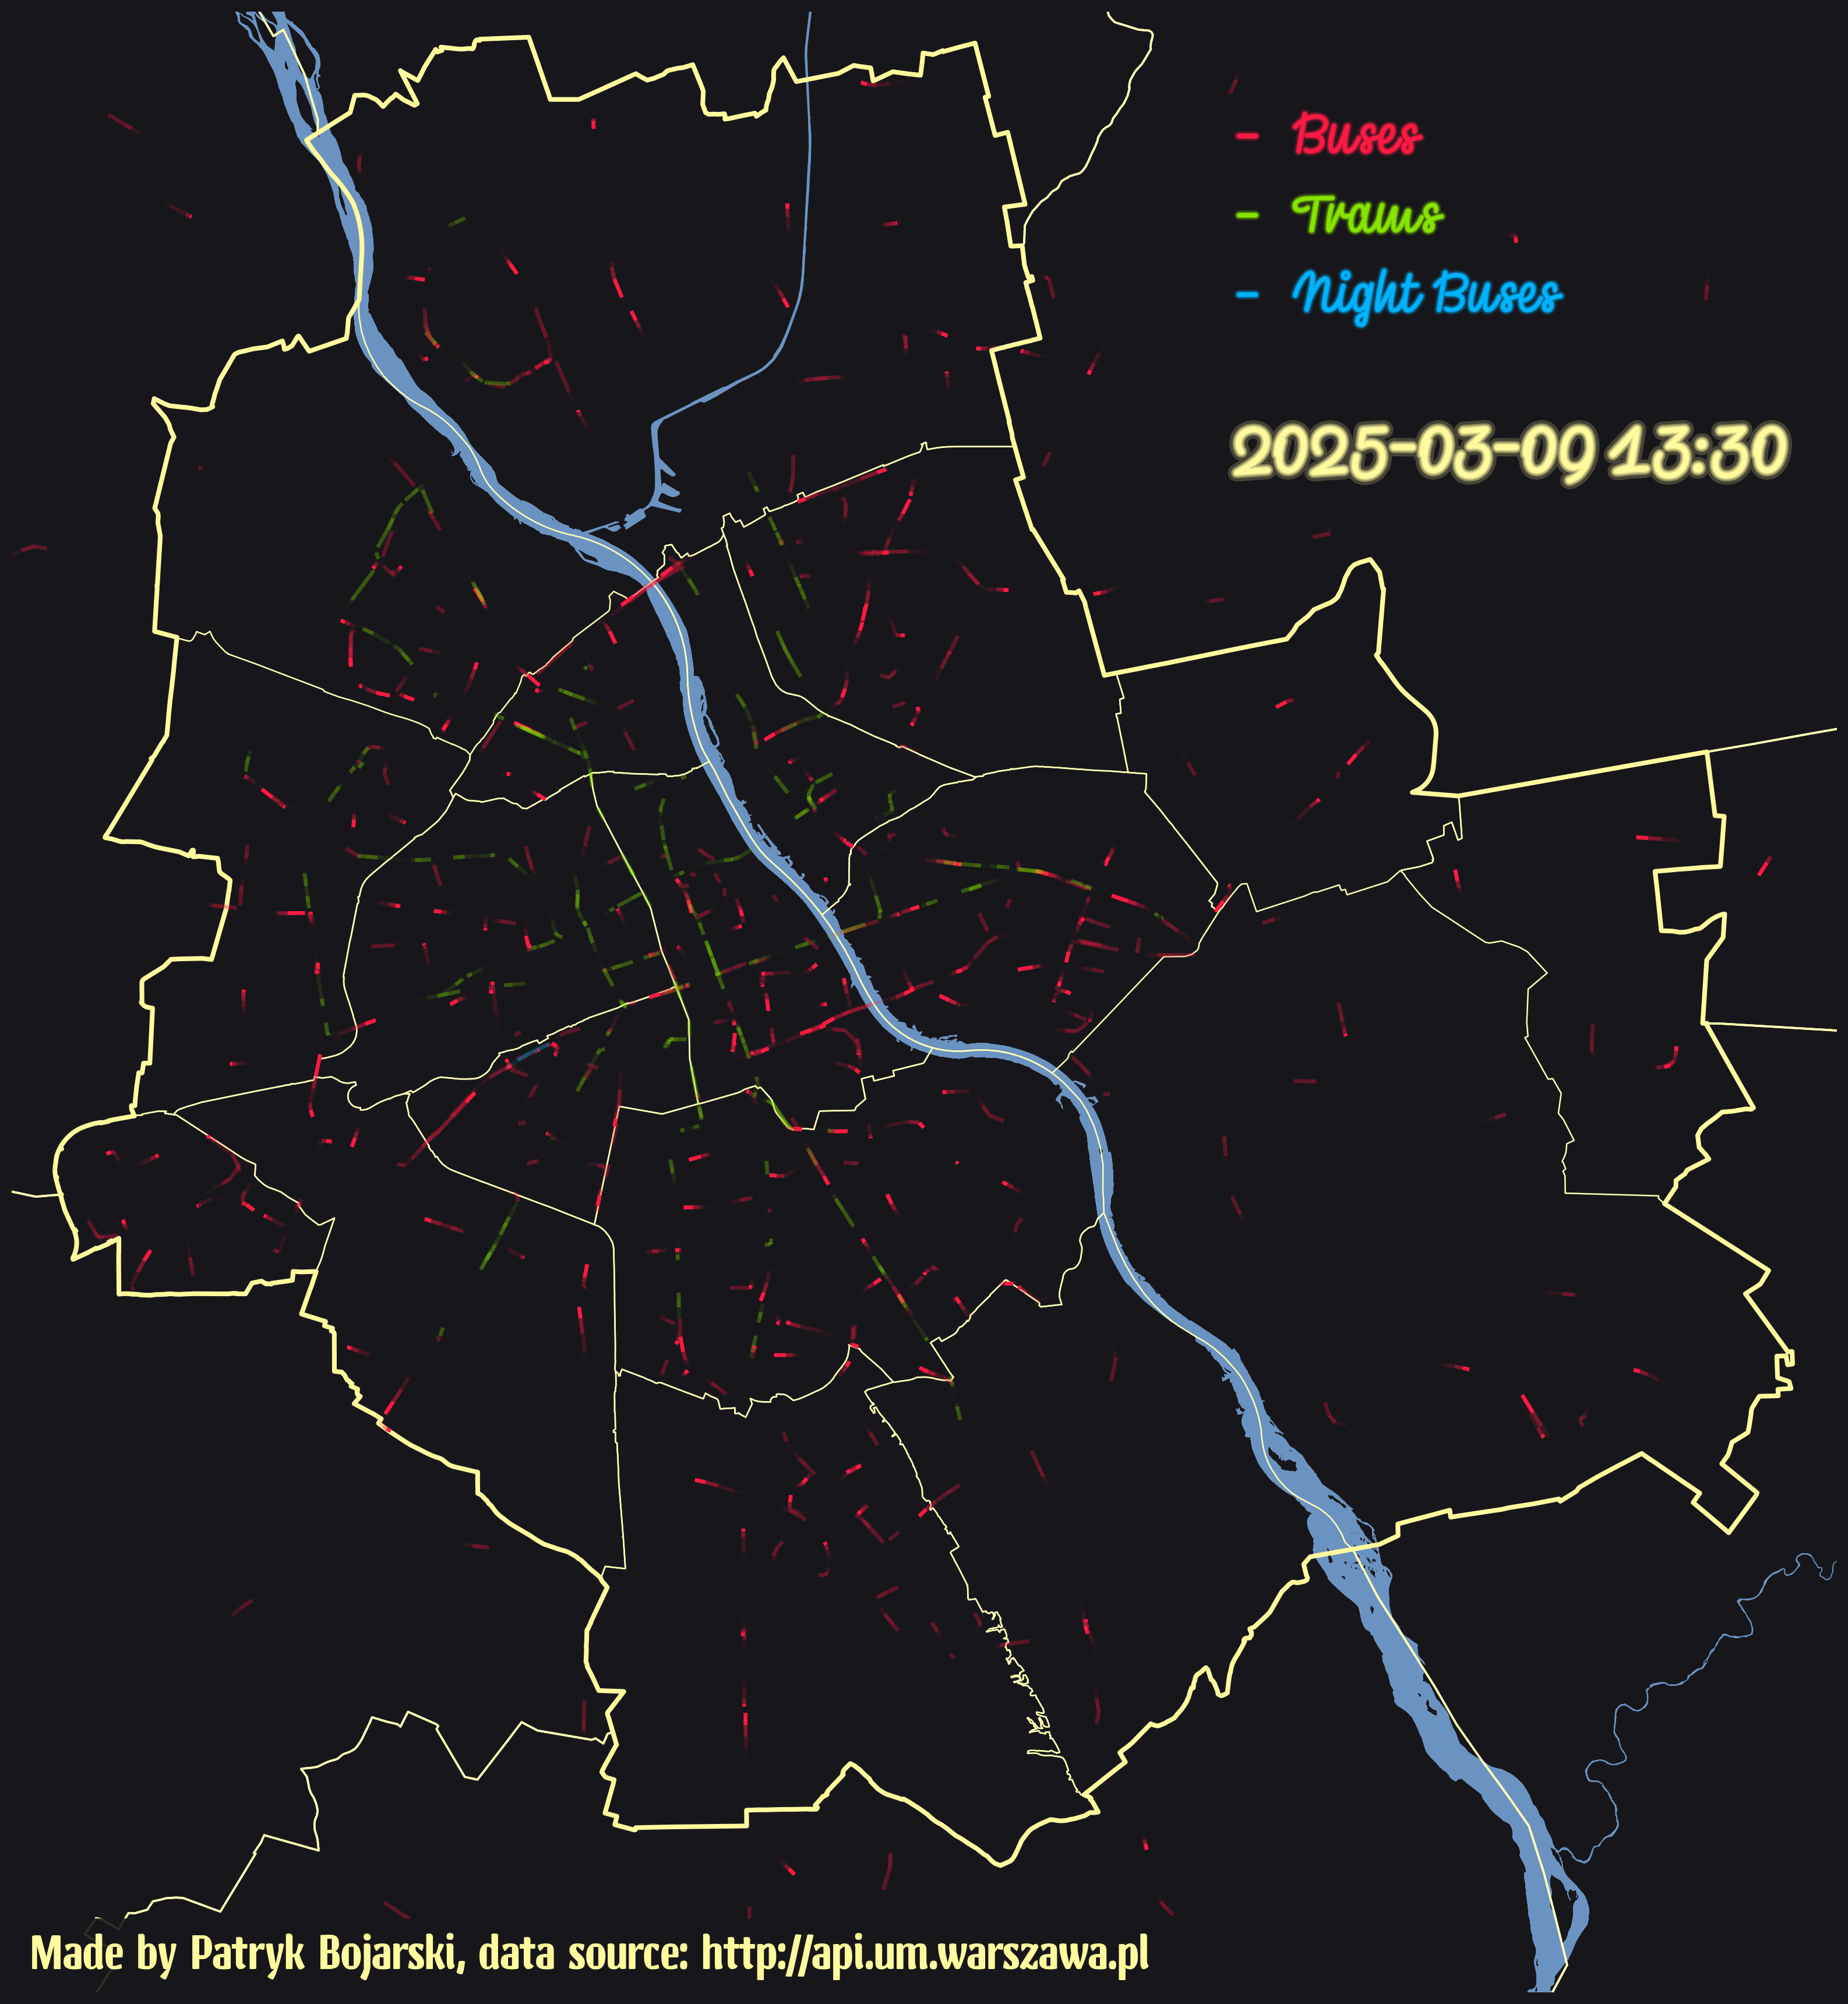

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.colors import to_rgb
from matplotlib import font_manager
import matplotlib.patheffects as path_effects

COLOR_BACKGROUND = "#17171B"
COLOR_WATER = "#6B93C1"
COLOR_PRIMARY_BORDER = "#FFFA9E"
COLOR_SECONDARY_BORDER = "#FFFEB5"

COLOR_BUS = "#FF1A44"
COLOR_TRAM = "#86E500"
COLOR_NIGHT = "#00B3FF"

# =========================
# OUTPUT CONFIG
# =========================
OUTPUT_MODE = "mp4"      # "png" or "mp4"
PNG_FRAME_INDEX = 16     # frame index if OUTPUT_MODE == "png"

# =========================
# PARAMETERS
# =========================
afterglow = 8
alpha_curve = 5

# =========================
# PREP DATA
# =========================
time_display = {v: k for k, v in TIME_BUCKETS.items()}

minx, miny, maxx, maxy = warsaw.total_bounds
minx *= 0.9995
miny *= 0.9995
maxx *= 1.0005
maxy *= 1.0001

fig_width = 16
width = maxx - minx
height = maxy - miny
aspect = height / width
fig_height = int(fig_width * aspect)

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=200)
# fig, ax = plt.subplots(figsize=(38.4, 21.6), dpi=100)

# =========================
# BACKGROUND MAP
# =========================
districts.boundary.plot(ax=ax, linewidth=0.9, color=COLOR_SECONDARY_BORDER, rasterized=True)
gminy.boundary.plot(ax=ax, linewidth=1.3, color=COLOR_SECONDARY_BORDER, rasterized=True)
warsaw.boundary.plot(ax=ax, linewidth=2.9, color=COLOR_PRIMARY_BORDER, rasterized=True)
rivers.plot(ax=ax, color=COLOR_WATER)
fig.patch.set_facecolor(COLOR_BACKGROUND)

havana_font = font_manager.FontProperties(fname="fonts/Havana-Regular.ttf")
cyrulic_font = font_manager.FontProperties(fname="fonts/Cyrulik-Rounded.ttf")

text_made = ax.text(
    .01, .03,
    "Made by Patryk Bojarski, data source: http://api.um.warszawa.pl",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=30,
    color=COLOR_PRIMARY_BORDER,
    fontproperties=cyrulic_font,
    bbox=dict(
        facecolor=COLOR_BACKGROUND,       # background color
        alpha=0.9,               # transparency
        edgecolor="none",        # no border
        boxstyle="round,pad=0.3" # rounded corners and padding
    )
)

text_time = ax.text(
    .67, .8,
    "",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=56,
    color=COLOR_PRIMARY_BORDER,
    fontproperties=havana_font,
    bbox=dict(
        facecolor=COLOR_BACKGROUND,       # background color
        alpha=0.95,               # transparency
        edgecolor="none",        # no border
        boxstyle="round,pad=0.3" # rounded corners and padding
    )
)

text_time.set_path_effects([
    path_effects.Stroke(linewidth=8, foreground=COLOR_PRIMARY_BORDER, alpha=0.2),  # outer glow
    path_effects.Stroke(linewidth=4, foreground=COLOR_PRIMARY_BORDER, alpha=0.4),  # mid glow
    path_effects.Stroke(linewidth=2, foreground=COLOR_PRIMARY_BORDER, alpha=0.6),  # inner glow
    path_effects.Normal()  # actual text on top
])

SEPARATOR = 0.04

text_bus = ax.text(
    .67, .95,
    "—   Buses",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=36,
    color=COLOR_BUS,
    fontproperties=havana_font,
    bbox=dict(
        facecolor=COLOR_BACKGROUND,       # background color
        alpha=0.95,               # transparency
        edgecolor="none",        # no border
        boxstyle="round,pad=0.3" # rounded corners and padding
    )
)

text_bus.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground=COLOR_BUS, alpha=0.2),  # outer glow
    path_effects.Stroke(linewidth=2, foreground=COLOR_BUS, alpha=0.4),  # mid glow
    path_effects.Stroke(linewidth=1, foreground=COLOR_BUS, alpha=0.6),  # inner glow
    path_effects.Normal()  # actual text on top
])

text_tram = ax.text(
    .67, .95 - SEPARATOR,
    "—   Trams",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=36,
    color=COLOR_TRAM,
    fontproperties=havana_font,
    bbox=dict(
        facecolor=COLOR_BACKGROUND,       # background color
        alpha=0.95,               # transparency
        edgecolor="none",        # no border
        boxstyle="round,pad=0.3" # rounded corners and padding
    )
)

text_tram.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground=COLOR_TRAM, alpha=0.2),  # outer glow
    path_effects.Stroke(linewidth=2, foreground=COLOR_TRAM, alpha=0.4),  # mid glow
    path_effects.Stroke(linewidth=1, foreground=COLOR_TRAM, alpha=0.6),  # inner glow
    path_effects.Normal()  # actual text on top
])

text_night = ax.text(
    .67, .95 - 2*SEPARATOR,
    "—   Night Buses",
    transform=ax.transAxes,
    ha="left",
    va="top",
    fontsize=36,
    color=COLOR_NIGHT,
    fontproperties=havana_font,
    bbox=dict(
        facecolor=COLOR_BACKGROUND,       # background color
        alpha=0.95,               # transparency
        edgecolor="none",        # no border
        boxstyle="round,pad=0.3" # rounded corners and padding
    )
)

text_night.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground=COLOR_NIGHT, alpha=0.2),  # outer glow
    path_effects.Stroke(linewidth=2, foreground=COLOR_NIGHT, alpha=0.4),  # mid glow
    path_effects.Stroke(linewidth=1, foreground=COLOR_NIGHT, alpha=0.6),  # inner glow
    path_effects.Normal()  # actual text on top
])

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect("equal")
ax.set_axis_off()
ax.margins(0)
ax.set_position([0, 0, 1, 1])
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax.set_autoscale_on(False)

# =========================
# GROUP DATA BY FRAME
# =========================
grouped = gps_data_final.groupby("time_bucket")
frames_sorted = sorted(grouped.groups.keys())

coords_by_time_bucket = {
    tb: grouped.get_group(tb)[["id", "x", "y", "type"]].reset_index(drop=True)
    for tb in frames_sorted
}

# =========================
# ID → TYPE MAP
# =========================
id_to_type = (
    gps_data_final[["id", "type"]]
    .drop_duplicates()
    .set_index("id")["type"]
    .to_dict()
)

TYPE_COLORS = {
    "bus":  COLOR_BUS,
    "tram": COLOR_TRAM,
    "night_bus": COLOR_NIGHT,
}

# =========================
# LINE COLLECTIONS
# =========================
trail_history = {line_id: [] for line_id in gps_data_final["id"].unique()}
lines_by_id = {}

for line_id in gps_data_final["id"].unique():
    lc = LineCollection(
        [],
        linewidths=2.4,
        animated=(OUTPUT_MODE == "mp4")
    )

    ax.add_collection(lc)
    lines_by_id[line_id] = lc

# =========================
# INIT
# =========================
def init():
    for lc in lines_by_id.values():
        lc.set_segments([])
    return list(lines_by_id.values())

# =========================
# UPDATE
# =========================
def update(frame_tb):
    df = coords_by_time_bucket.get(frame_tb, pd.DataFrame(columns=["id", "x", "y", "type"]))

    for line_id in trail_history.keys():
        # Get current points for this frame
        pts = df[df["id"] == line_id][["x", "y"]].to_numpy()

        # Add new point if exists
        if pts.size > 0:
            for row in pts:
                trail_history[line_id].append((frame_tb, row))

        # Keep only recent points
        trail_history[line_id] = [
            (tb, pt)
            for tb, pt in trail_history[line_id]
            if frame_tb - tb < afterglow
        ]

        recent = trail_history[line_id]

        if len(recent) < 2:
            lines_by_id[line_id].set_segments([])
            continue

        trail_pts = np.vstack([pt for _, pt in recent])
        segments = [[trail_pts[i], trail_pts[i + 1]] for i in range(len(trail_pts) - 1)]

        # Compute alpha fading
        # If vehicle disappeared, fade out the tail gradually
        alphas = np.linspace(0.1, 1, len(segments)) ** alpha_curve

        # Reduce the alpha of the last segment if vehicle is gone
        if pts.size == 0:
            alphas[-1] *= 0.3  # reduce visibility gradually

        veh_type = id_to_type.get(line_id, "bus")
        r, g, b = to_rgb(TYPE_COLORS.get(veh_type, "#FF0000"))

        colors = np.zeros((len(segments), 4))
        colors[:, 0] = r
        colors[:, 1] = g
        colors[:, 2] = b
        colors[:, 3] = alphas

        lines_by_id[line_id].set_segments(segments)
        lines_by_id[line_id].set_color(colors)

    # text_time.set_text(time_display[frame_tb].strftime("%Y-%m-%d %H:%M"))
    rounded_time = round_to_nearest_30min(time_display[frame_tb])
    text_time.set_text(rounded_time.strftime("%Y-%m-%d %H:%M"))


    return list(lines_by_id.values())


# =========================
# OUTPUT SWITCH
# =========================
if OUTPUT_MODE == "png":

    frame_tb = frames_sorted[PNG_FRAME_INDEX]

    # reset state
    for k in trail_history:
        trail_history[k].clear()

    init()

    # WARM UP HISTORY (this is the key!)
    for tb in frames_sorted[:PNG_FRAME_INDEX + 1]:
        update(tb)

    fig.canvas.draw()

    fig.savefig(
        "frame.png",
        dpi=200,
        bbox_inches="tight",
        pad_inches=0
    )

elif OUTPUT_MODE == "mp4":
    ani = FuncAnimation(
        fig,
        update,
        frames=frames_sorted,
        init_func=init,
        blit=True
    )

    # writer = FFMpegWriter(
    #     fps=24,
    #     codec="libx264",
    #     bitrate=12000,
    #     extra_args=[
    #         "-pix_fmt", "yuv420p",
    #         "-profile:v", "main",
    #         "-level", "4.1",
    #         "-movflags", "+faststart"
    #     ],
    # )

    writer = FFMpegWriter(
        fps=50,
        codec="libx264",
        bitrate=12000,
        extra_args=[
            "-pix_fmt", "yuv420p",
            "-profile:v", "main",
            "-level", "4.1",
            "-movflags", "+faststart",
        ],
    )

    ani.save("animation_v6.mp4", writer=writer, dpi=int(fig.dpi))

else:
    raise ValueError("OUTPUT_MODE must be 'png' or 'mp4'")